In [1]:
# Importando as bibliotecas
from CoolProp.CoolProp import PropsSI, PhaseSI
import pprint
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Calcula qualquer ponto informando dicionario com duas variaveis
def calculate_point(point):
    variables = ['T', 'H', 'S', 'Q', 'P']
    input_variables = list(point.keys())
    output_variables = [variable for variable in variables if variable not in input_variables]
    output_values = PropsSI(output_variables, 
                            input_variables[0], 
                            point[input_variables[0]], 
                            input_variables[1], 
                            point[input_variables[1]], 
                            input_values['refrigerant']
    )

    for index, variable in enumerate(output_variables):
        point[variable] = output_values[index]

    return point

In [3]:
# Calcula ciclo baseado nas variaveis de entrada
def calculate_cycle(cycle_inputs):
    t_0 = cycle_inputs['t_external_env']
    
    point_1_saturado = {'Q': 1, 'T': cycle_inputs['t_internal_env'] - cycle_inputs['approach_evaporator']}
    calculate_point(point_1_saturado)

    point_1 = {'P': point_1_saturado['P'], 'T': point_1_saturado['T'] + cycle_inputs['superheating']}
    calculate_point(point_1)

    point_3_saturado = {'Q': 0, 'T': cycle_inputs['t_external_env'] + cycle_inputs['approach_condenser']}
    calculate_point(point_3_saturado)

    point_3 = {'P': point_3_saturado['P'], 'T': point_3_saturado['T'] - cycle_inputs['subcooling']}
    calculate_point(point_3)

    point_2_isen = {'S': point_1['S'], 'P': point_3['P']}
    calculate_point(point_2_isen)

    point_2 = {'P': point_3['P'], 'H': point_1['H'] + (point_2_isen['H'] - point_1['H']) / cycle_inputs['isentropic_efficiency']}
    calculate_point(point_2)

    point_4 = {'P': point_1['P'], 'H': point_3['H']}
    calculate_point(point_4)

    m = cycle_inputs['q_evaporator'] / (point_1['H'] - point_4['H'])
    cop = (point_1['H'] - point_4['H']) / (point_2['H'] - point_1['H']) 
    
    compressor_exergy_destruction = m * t_0 * (point_2['S'] - point_1['S'])
    condenser_exergy_destruction = m * t_0 * (point_3['S'] - point_2['S'] + (point_2['H'] - point_3['H']) / cycle_inputs['t_external_env'])
    expansion_valve_exergy_destruction = m * t_0 * (point_4['S'] - point_3['S'])
    evaporator_exergy_destruction = m * t_0 * (point_1['S'] - point_4['S'] - (point_1['H'] - point_4['H']) / cycle_inputs['t_internal_env'])
    total_exergy_destruction = compressor_exergy_destruction + condenser_exergy_destruction \
        + expansion_valve_exergy_destruction + evaporator_exergy_destruction
    
    return {
        'cycle_inputs': cycle_inputs,
        'point_1': point_1,
        'point_2': point_2,
        'point_3': point_3,
        'point_4': point_4,
        'm': m,
        'cop': cop,
        'exergy_efficiency': cop / cycle_inputs['cop_carnot'],
        'exergy_efficiency_components': 1 - total_exergy_destruction / (m * (point_2['H'] - point_1['H']))
    }

In [4]:
# Calcula melhor ciclo baseado nas variaveis de entrada e ranges de entrada
def calculate_best_cycle(cycle_inputs, cycle_ranges):
    results = pd.DataFrame(columns=['refrigerant', 'subcooling', 'superheating', 'cop'])
    result_by_cop = {}
    cops = []
    for subcooling in input_ranges['subcooling_range']:
        for refrigerant in input_ranges['refrigerants']:
            for superheating in input_ranges['superheating_range']:
                input_values['subcooling'] = subcooling
                input_values['refrigerant'] = refrigerant
                input_values['superheating'] = superheating
                cycle = calculate_cycle(input_values)   
                results = results.append({
                    'refrigerant': refrigerant,
                    'subcooling': subcooling,
                    'superheating': superheating,
                    'cop': cycle['cop']
                }, ignore_index=True)
                result_by_cop[cycle['cop']] = cycle
                cops.append(cycle['cop'])
    return results, result_by_cop[max(cops)]

In [5]:
def main():
    _, best_cycle = calculate_best_cycle(input_values, input_ranges)
    print('#'*30)
    print('Refrigerant: ', best_cycle['cycle_inputs']['refrigerant'])
    print('Subcooling: ', best_cycle['cycle_inputs']['subcooling'])
    print('Superheating: ', best_cycle['cycle_inputs']['superheating'])
    print('COP: ', best_cycle['cop'])
    print('Exergy efficiency: ', best_cycle['exergy_efficiency'])
    print('Exergy efficiency components: ', best_cycle['exergy_efficiency_components'])
    print('#'*30)

In [6]:
# Variaveis de entrada
input_values = {
    't_external_env': 35 + 273.15,
    't_internal_env': 18 + 273.15,
    'approach_condenser': 10,
    'approach_evaporator': 10,
    'q_evaporator': 9000 * 0.293071,
    'isentropic_efficiency': 0.7
}

input_values['cop_carnot'] = input_values['t_internal_env'] / (input_values['t_external_env'] - input_values['t_internal_env'])

input_ranges = {
#     'superheating_range': range(5,11),
#     'subcooling_range': range(5,11),
#     'refrigerants': ['R134a', 'R22', 'R290', 'R600a', 'R1234yf', 'NH3']
#     'superheating_range': range(5,6),
#     'subcooling_range': range(5,11),
#     'refrigerants': ['R134a', 'R22']
    'superheating_range': range(5,11),
    'subcooling_range': range(5,11),
    'refrigerants': ['R134a']
}

main()

##############################
Refrigerant:  R134a
Subcooling:  10
Superheating:  10
COP:  4.759264926411773
Exergy efficiency:  0.2778894169637649
Exergy efficiency components:  0.2778894169637649
##############################


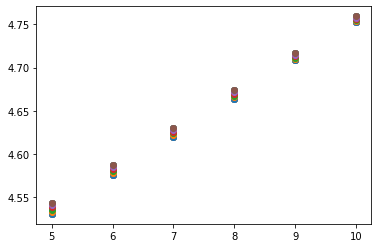

In [7]:
results, _ = calculate_best_cycle(input_values, input_ranges)
results_R134a = results[results['refrigerant'] == 'R134a']
ax = plt.subplot()
for sh in results_R134a['superheating']:
    r = results_R134a[results_R134a['superheating'] == sh]
    ax.plot(r['subcooling'], r['cop'], 'o')
plt.show()

In [8]:
# Superheating e Subcooling
 
# Calcula proximo k

def calculate_next_both(opt_input_values, current_superheating, current_subcooling, alpha):
    old_superheating = opt_input_values['superheating']
    old_subcooling = opt_input_values['subcooling']

    cycle_oldsub_oldsup = calculate_cycle(opt_input_values)
    opt_input_values['superheating'] = current_superheating
    cycle_oldsub_cursup = calculate_cycle(opt_input_values)
    opt_input_values['subcooling'] = current_subcooling
    cycle_cursub_oldsup = calculate_cycle(opt_input_values)

    gradient_sup = (cycle_oldsub_cursup['cop'] - cycle_oldsub_oldsup['cop']) / (current_superheating - old_superheating)
    gradient_sub = (cycle_cursub_oldsup['cop'] - cycle_oldsub_oldsup['cop']) / (current_subcooling - old_subcooling)
    
    next_superheating = opt_input_values['superheating'] + alpha*gradient_sup
    next_subcooling = opt_input_values['subcooling'] + alpha*gradient_sub

    return {
        'superheating': next_superheating,
        'subcooling': next_subcooling
    }

# Variaveis de entrada para otimizacao
opt_input_values = {
    't_external_env': 35 + 273.15,
    't_internal_env': 18 + 273.15,
    'approach_condenser': 10,
    'approach_evaporator': 10,
    'q_evaporator': 9000 * 0.293071,
    'isentropic_efficiency': 0.7,
    'superheating': 5,
    'subcooling': 5,
    'refrigerant': 'R134a'
}

opt_input_values['cop_carnot'] = opt_input_values['t_internal_env'] \
/ (opt_input_values['t_external_env'] - opt_input_values['t_internal_env'])
    
k = 0
current_pass = {}
while k < 20:
    if not bool(current_pass):
        current_pass['superheating'] = 6
        current_pass['subcooling'] = 6
    next_pass = calculate_next_both(opt_input_values, current_pass['superheating'], current_pass['subcooling'], 10)
    current_pass = next_pass
    k += 1
    
    print_input_values = opt_input_values
    print_cycle = calculate_cycle(print_input_values)
    print('#'*30)
    print('Subcooling: ', print_cycle['cycle_inputs']['subcooling'])
    print('Superheating: ', print_cycle['cycle_inputs']['superheating'])
    print('COP: ', print_cycle['cop'])
    print('#'*30)
    
    
opt_input_values['superheating'] = current_pass['superheating']
opt_input_values['subcooling'] = current_pass['subcooling']
opt_cycle = calculate_cycle(opt_input_values)

print('#'*30)
print('Subcooling: ', opt_cycle['cycle_inputs']['subcooling'])
print('Superheating: ', opt_cycle['cycle_inputs']['superheating'])
print('COP: ', opt_cycle['cop'])
print('#'*30)

##############################
Subcooling:  6
Superheating:  6
COP:  4.577540860376346
##############################
##############################
Subcooling:  6.468172013830346
Superheating:  6.0242351720368195
COP:  4.59831326660846
##############################
##############################
Subcooling:  6.911863768537434
Superheating:  6.046510629166688
COP:  4.617956908614756
##############################
##############################
Subcooling:  7.354595502852951
Superheating:  6.067666678431087
COP:  4.63751669568078
##############################
##############################
Subcooling:  7.7963932225548
Superheating:  6.087764351602228
COP:  4.656994957762124
##############################
##############################
Subcooling:  8.237279655705445
Superheating:  6.106807557481481
COP:  4.676393728882578
##############################
##############################
Subcooling:  8.677274394981673
Superheating:  6.1248000737062025
COP:  4.695714876387134
###############

In [12]:
# Superheating
 
# Calcula proximo k

def calculate_next_superheating(opt_input_values, current_superheating, alpha):
    old_superheating = opt_input_values['superheating']

    cycle_oldsub_oldsup = calculate_cycle(opt_input_values)
    opt_input_values['superheating'] = current_superheating
    cycle_oldsub_cursup = calculate_cycle(opt_input_values)

    gradient_sup = (cycle_oldsub_cursup['cop'] - cycle_oldsub_oldsup['cop']) / (current_superheating - old_superheating)
    
    next_superheating = opt_input_values['superheating'] + alpha*gradient_sup

    return {
        'superheating': next_superheating
    }

# Variaveis de entrada para otimizacao
opt_input_values = {
    't_external_env': 35 + 273.15,
    't_internal_env': 18 + 273.15,
    'approach_condenser': 10,
    'approach_evaporator': 10,
    'q_evaporator': 9000 * 0.293071,
    'isentropic_efficiency': 0.7,
    'cop_carnot': input_values['t_internal_env'] / (input_values['t_external_env'] - input_values['t_internal_env']),
    'superheating': 5,
    'subcooling': 5,
    'refrigerant': 'R134a'
}

input_values['cop_carnot'] = input_values['t_internal_env'] / (input_values['t_external_env'] - input_values['t_internal_env'])
    
k = 0
current_pass = {}
while k < 20:
    if not bool(current_pass):
        current_pass['superheating'] = 6
    next_pass = calculate_next_superheating(opt_input_values, current_pass['superheating'], 10)
    current_pass = next_pass
    k += 1
    
    print_input_values = opt_input_values
    print_cycle = calculate_cycle(print_input_values)
    print('#'*30)
    print('Subcooling: ', print_cycle['cycle_inputs']['subcooling'])
    print('Superheating: ', print_cycle['cycle_inputs']['superheating'])
    print('COP: ', print_cycle['cop'])
    print('#'*30)
    
    
opt_input_values['superheating'] = current_pass['superheating']
opt_cycle = calculate_cycle(opt_input_values)

print('#'*30)
print('Subcooling: ', opt_cycle['cycle_inputs']['subcooling'])
print('Superheating: ', opt_cycle['cycle_inputs']['superheating'])
print('COP: ', opt_cycle['cop'])
print('#'*30)

##############################
Subcooling:  5
Superheating:  6
COP:  4.5331471761969935
##############################
##############################
Subcooling:  5
Superheating:  6.0242351720368195
COP:  4.533207094712863
##############################
##############################
Subcooling:  5
Superheating:  6.048958956039181
COP:  4.5332682782984435
##############################
##############################
Subcooling:  5
Superheating:  6.073705809342185
COP:  4.533329576609576
##############################
##############################
Subcooling:  5
Superheating:  6.098475952997311
COP:  4.5333909903058665
##############################
##############################
Subcooling:  5
Superheating:  6.123269388653261
COP:  4.53345251950413
##############################
##############################
Subcooling:  5
Superheating:  6.148086118015557
COP:  4.533514164321227
##############################
##############################
Subcooling:  5
Superheating:  6.172926142741

In [14]:
# Subcooling
 
# Calcula proximo k

def calculate_next_subcooling(opt_input_values, current_subcooling, alpha):
    old_subcooling = opt_input_values['subcooling']

    cycle_oldsub_oldsup = calculate_cycle(opt_input_values)
    opt_input_values['subcooling'] = current_subcooling
    cycle_cursub_oldsup = calculate_cycle(opt_input_values)

    gradient_sub = (cycle_cursub_oldsup['cop'] - cycle_oldsub_oldsup['cop']) / (current_subcooling - old_subcooling)

    next_subcooling = opt_input_values['subcooling'] + alpha*gradient_sub

    return {
        'subcooling': next_subcooling
    }

# Variaveis de entrada para otimizacao
opt_input_values = {
    't_external_env': 35 + 273.15,
    't_internal_env': 18 + 273.15,
    'approach_condenser': 10,
    'approach_evaporator': 10,
    'q_evaporator': 9000 * 0.293071,
    'isentropic_efficiency': 0.7,
    'superheating': 5,
    'subcooling': 5,
    'refrigerant': 'R134a'
}

opt_input_values['cop_carnot'] = opt_input_values['t_internal_env'] \
/ (opt_input_values['t_external_env'] - opt_input_values['t_internal_env'])
    
k = 0
current_pass = {}
while k < 20:
    if not bool(current_pass):
        current_pass['subcooling'] = 6
    next_pass = calculate_next_subcooling(opt_input_values, current_pass['subcooling'], 10)
    current_pass = next_pass
    k += 1
    
    print_input_values = opt_input_values
    print_cycle = calculate_cycle(print_input_values)
    print('#'*30)
    print('Subcooling: ', print_cycle['cycle_inputs']['subcooling'])
    print('Superheating: ', print_cycle['cycle_inputs']['superheating'])
    print('COP: ', print_cycle['cop'])
    print('#'*30)
    
    
opt_input_values['subcooling'] = current_pass['subcooling']
opt_cycle = calculate_cycle(opt_input_values)

print('#'*30)
print('Subcooling: ', opt_cycle['cycle_inputs']['subcooling'])
print('Superheating: ', opt_cycle['cycle_inputs']['superheating'])
print('COP: ', opt_cycle['cop'])
print('#'*30)

##############################
Subcooling:  6
Superheating:  5
COP:  4.575364393136945
##############################
##############################
Subcooling:  6.446407341436332
Superheating:  5
COP:  4.595233113995086
##############################
##############################
Subcooling:  6.891487854543769
Superheating:  5
COP:  4.6150071075084
##############################
##############################
Subcooling:  7.335766876675231
Superheating:  5
COP:  4.634710461706394
##############################
##############################
Subcooling:  7.779257413398436
Superheating:  5
COP:  4.654344418768781
##############################
##############################
Subcooling:  8.221971641473173
Superheating:  5
COP:  4.673910162894139
##############################
##############################
Subcooling:  8.663921388840581
Superheating:  5
COP:  4.693408842571329
##############################
##############################
Subcooling:  9.105118149181294
Superheating:  5
C